In [1]:
# Baixa o arquivo zip do dataset
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/content/cats_and_dogs.zip"

# Cria um diretório para extrair os arquivos
import os
import zipfile

local_zip = '/content/cats_and_dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Dataset baixado e extraído com sucesso!")

--2025-06-09 12:52:14--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.1.108.212, 2a02:26f0:1180:294::317f, 2a02:26f0:1180:298::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.1.108.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/content/cats_and_dogs.zip’

/content/cats_and_d 100%[===================>] 786.67M   144MB/s    in 5.1s    

2025-06-09 12:52:19 (153 MB/s) - ‘/content/cats_and_dogs.zip’ saved [824887076/824887076]

Dataset baixado e extraído com sucesso!


In [3]:
import os
import tensorflow as tf # Import the tensorflow library

# Diretório principal
base_dir = '/content/PetImages'
cat_dir = os.path.join(base_dir, 'Cat')
dog_dir = os.path.join(base_dir, 'Dog')

# Remove arquivos que não são imagens ou estão corrompidos
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            # Tenta abrir o arquivo para verificar se é uma imagem válida
            fobj = open(fpath, "rb")
            # Use tf.compat.as_bytes from the imported tensorflow library
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Deleta o arquivo corrompido
            os.remove(fpath)

print(f"Arquivos corrompidos removidos: {num_skipped}")

Arquivos corrompidos removidos: 1590


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Parâmetros para o nosso modelo
IMG_SIZE = 160 # Tamanho da imagem para a MobileNetV2
BATCH_SIZE = 32 # Tamanho do lote

In [5]:
# Caminho para o diretório com as imagens
image_dir = "/content/PetImages"

# Criar dataset de treinamento (80% dos dados)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Criar dataset de validação (20% dos dados)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Otimizar o carregamento de dados
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [6]:
# 1. Camada de Aumento de Dados
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
  ]
)

# 2. Camada para reescalar os pixels para o intervalo [-1, 1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 3. Carregar o modelo base pré-treinado e congelar seus pesos
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Não incluir a camada final
                                               weights='imagenet')
base_model.trainable = False # Congelar o modelo

# 4. Construir o modelo final
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # training=False para manter as camadas de BatchNormalization congeladas
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Dropout para regularização
outputs = layers.Dense(1)(x) # Camada de saída para classificação binária

model = keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Compilar o modelo
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Resumo do modelo
model.summary()

# Treinar o modelo
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 47s 64ms/step - accuracy: 0.6726 - loss: 0.6078 - val_accuracy: 0.9430 - val_loss: 0.1526
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.9081 - loss: 0.2115 - val_accuracy: 0.9652 - val_loss: 0.0996
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.9316 - loss: 0.1643 - val_accuracy: 0.9703 - val_loss: 0.0817
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.9373 - loss: 0.1468 - val_accuracy: 0.9739 - val_loss: 0.0722
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.9450 - loss: 0.1322 - val_accuracy: 0.9763 - val_loss: 0.0663
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9451 - loss: 0.1274 - val_accuracy: 0.9774 - val_loss: 0.0628
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.9486 - loss: 0.1237 - val_accuracy: 0.9791 - val_loss: 0.0608
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.9476 - loss: 0.1216 - 

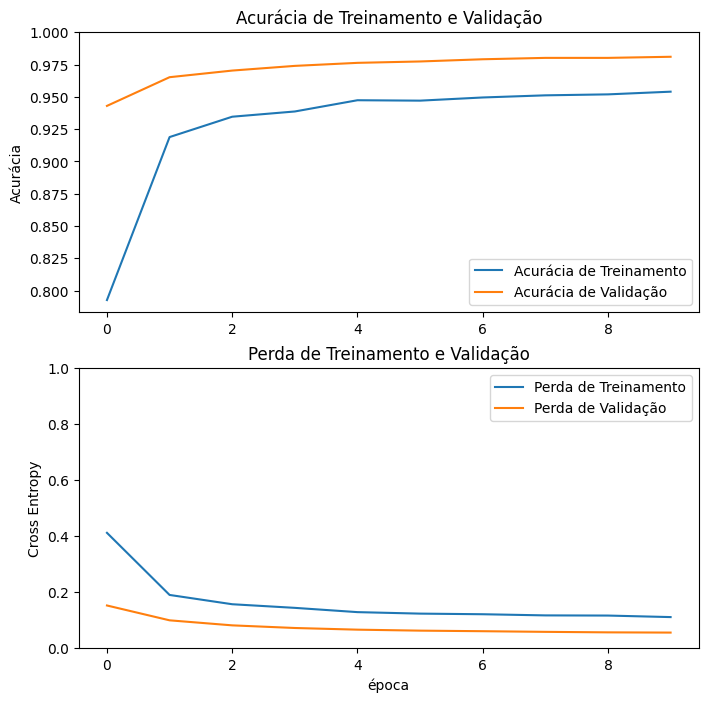

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acurácia de Treinamento')
plt.plot(val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.ylabel('Acurácia')
plt.ylim([min(plt.ylim()),1])
plt.title('Acurácia de Treinamento e Validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda de Treinamento')
plt.plot(val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Perda de Treinamento e Validação')
plt.xlabel('época')
plt.show()